# 911 Calls Kaggle

This project consists of analyzing 911 call data from the Kaggle dataset. The data set can be found here:

https://www.kaggle.com/mchirico/montcoalert

Essentially the fields consists of the following:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)

In [1]:
%matplotlib inline

In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load CSV data in pandas

In [3]:
project_dir = os.path.join(os.getcwd(), os.pardir)
data_dir = os.path.join(project_dir, 'data')
data_file = os.path.join(data_dir, '911.v39.csv')

df = pd.read_csv(data_file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175255 entries, 0 to 175254
Data columns (total 9 columns):
lat          175255 non-null float64
lng          175255 non-null float64
desc         175255 non-null object
zip          153734 non-null float64
title        175255 non-null object
timeStamp    175255 non-null object
twp          175195 non-null object
addr         175255 non-null object
e            175255 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 12.0+ MB


In [5]:
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


## Initial Questions of Interest

**Top 5 zipcodes for call?**

In [6]:
df['zip'].value_counts().nlargest(5)

19401.0    12159
19464.0    11818
19403.0     8763
19446.0     8395
19406.0     5749
Name: zip, dtype: int64

**Top 5 townships for calls?**

In [7]:
df['twp'].value_counts().nlargest(5)

LOWER MERION    15037
ABINGTON        10657
NORRISTOWN      10201
UPPER MERION     9138
CHELTENHAM       8002
Name: twp, dtype: int64

**Unique title code count?**

In [8]:
len(df['title'].unique())

122

**Most frequent address for calls?**

In [9]:
df['addr'].value_counts().nlargest(20)

SHANNONDELL DR & SHANNONDELL BLVD                 1698
MAIN ST & OLD SUMNEYTOWN PIKE                      688
THE FAIRWAY  & RYDAL RD                            512
EVERGREEN RD & W LIGHTCAP RD                       442
GULPH RD & KIRK AVE                                413
BLACK ROCK RD & S TRAPPE RD                        410
DAVISVILLE RD & PENNYPACK RD                       383
EAGLEVILLE RD & SUNDERLAND DR                      377
SCHUYLKILL EXPY & WEADLEY RD OVERPASS              351
GERMANTOWN PIKE & HANNAH AVE                       350
SCHUYLKILL EXPY & CONSHOHOCKEN STATE UNDERPASS     330
PRISON RD & PIGGERY RD                             329
BETHLEHEM PIKE & NORTH WALES RD                    319
SUSQUEHANNA RD & HUNTINGDON RD                     312
MORELAND RD & EASTON RD                            308
BETHLEHEM PIKE & TAYLOR RD                         304
NO LOCATION - NEIGHBORING COUNTY                   302
HUNTINGDON PIKE & MOREDON RD                       301
CITY AVE &

## Adding new features / Further Questions

**Extract the Reason/Department from title**

**What are the reasons?**

In [47]:
df['reason'] = df['title'].apply(lambda s: s.split(':')[0])
df['reason exp'] = df['title'].apply(lambda s: ''.join(s.split(':')[1:]).strip())

In [11]:
df['reason'].value_counts()

EMS        87116
Traffic    61874
Fire       26265
Name: reason, dtype: int64

In [34]:
df['reason exp'].value_counts()

 VEHICLE ACCIDENT -              41096
 DISABLED VEHICLE -              12545
 VEHICLE ACCIDENT                 9976
 FIRE ALARM                       9828
 RESPIRATORY EMERGENCY            9102
 CARDIAC EMERGENCY                8784
 FALL VICTIM                      8725
 ROAD OBSTRUCTION -               5408
 SUBJECT IN PAIN                  4874
 HEAD INJURY                      4563
 UNKNOWN MEDICAL EMERGENCY        3189
 SYNCOPAL EPISODE                 3046
 SEIZURES                         2950
 GENERAL WEAKNESS                 2664
 ALTERED MENTAL STATUS            2542
 ABDOMINAL PAINS                  2534
 FIRE INVESTIGATION               2526
 MEDICAL ALERT ALARM              2388
 HEMORRHAGING                     2219
 OVERDOSE                         2212
 CVA/STROKE                       2180
 UNCONSCIOUS SUBJECT              2166
 NAUSEA/VOMITING                  2018
 GAS-ODOR/LEAK                    1967
 BUILDING FIRE                    1777
 HAZARDOUS ROAD CONDITION

## Clean up some duplicates reason explainations.

We can cluster the labels on edit distance to find similar labels to figure out what needs to be cleaned up.

In [92]:
from nltk.metrics.distance import edit_distance
from scipy.cluster.hierarchy import linkage

data = df['reason exp'].unique()

def d(coord):
    i, j = coord
    return edit_distance(data[i], data[j])

coords = np.triu_indices(len(data), 1)
result = np.apply_along_axis(d, 0, coords)
clust = linkage(result)

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


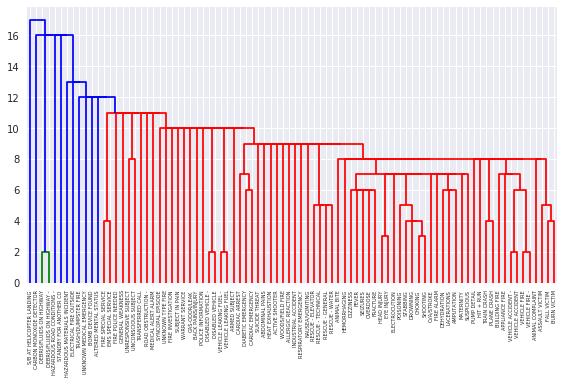

In [116]:
from scipy.cluster.hierarchy import dendrogram

dend = dendrogram(clust, labels=data)
plt.tight_layout()

We can simply use the shorter label to fix these labels. To be safe we can look at the labels with a particular edit distance...

In [99]:
fix_labels = {}

for row in clust:
    i = row[0]
    j = row[1]
    dist = row[2]    
    
    if i < len(data) and j < len(data) and dist <= 2:
        a = data[i]
        b = data[j]
        print(a, b)
        
        if len(b) < len(a):
            fix_labels[a] = b
        else:
            fix_labels[b] = a

VEHICLE LEAKING FUEL - VEHICLE LEAKING FUEL
DEBRIS/FLUIDS ON HIGHWAY DEBRIS/FLUIDS ON HIGHWAY -
VEHICLE ACCIDENT - VEHICLE ACCIDENT
DISABLED VEHICLE - DISABLED VEHICLE
VEHICLE FIRE VEHICLE FIRE -


/software/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/software/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Here are the labels we will replace.

In [100]:
fix_labels

{'DEBRIS/FLUIDS ON HIGHWAY -': 'DEBRIS/FLUIDS ON HIGHWAY',
 'DISABLED VEHICLE -': 'DISABLED VEHICLE',
 'VEHICLE ACCIDENT -': 'VEHICLE ACCIDENT',
 'VEHICLE FIRE -': 'VEHICLE FIRE',
 'VEHICLE LEAKING FUEL -': 'VEHICLE LEAKING FUEL'}

In [113]:
# combine duplicate labels and remove ending dashes
def fix_reason_exp(v):
    l = v
    if l in fix_labels:
        l = fix_labels[v]

    if l.strip().endswith(' -'):
        l = ''.join(l.split(' -')[:-1])
        
    return l

df['reason exp'] = df['reason exp'].apply(fix_reason_exp)

In [106]:
df['reason exp'].unique()

array(['BACK PAINS/INJURY', 'DIABETIC EMERGENCY', 'GAS-ODOR/LEAK',
       'CARDIAC EMERGENCY', 'DIZZINESS', 'HEAD INJURY', 'NAUSEA/VOMITING',
       'RESPIRATORY EMERGENCY', 'SYNCOPAL EPISODE', 'VEHICLE ACCIDENT',
       'DISABLED VEHICLE', 'APPLIANCE FIRE', 'GENERAL WEAKNESS',
       'CARBON MONOXIDE DETECTOR', 'UNKNOWN MEDICAL EMERGENCY',
       'UNRESPONSIVE SUBJECT', 'ALTERED MENTAL STATUS', 'FIRE ALARM',
       'CVA/STROKE', 'ROAD OBSTRUCTION -', 'SUBJECT IN PAIN',
       'HEMORRHAGING', 'FALL VICTIM', 'ASSAULT VICTIM', 'SEIZURES',
       'MEDICAL ALERT ALARM', 'ABDOMINAL PAINS', 'PUMP DETAIL',
       'FIRE INVESTIGATION', 'OVERDOSE', 'MATERNITY',
       'UNCONSCIOUS SUBJECT', 'CHOKING', 'LACERATIONS',
       'TRASH/DUMPSTER FIRE', 'UNKNOWN TYPE FIRE', 'BUILDING FIRE',
       'ELECTRICAL FIRE OUTSIDE', 'DEBRIS/FLUIDS ON HIGHWAY', 'FEVER',
       'ALLERGIC REACTION', 'VEHICLE LEAKING FUEL', 'FRACTURE',
       'BURN VICTIM', 'RESCUE - GENERAL', 'WOODS/FIELD FIRE',
       'FIRE SPECI

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


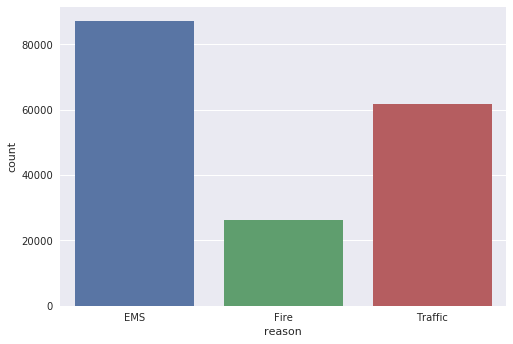

In [12]:
sns.countplot(x='reason', data=df)

## Top 20 Reason Explainations

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


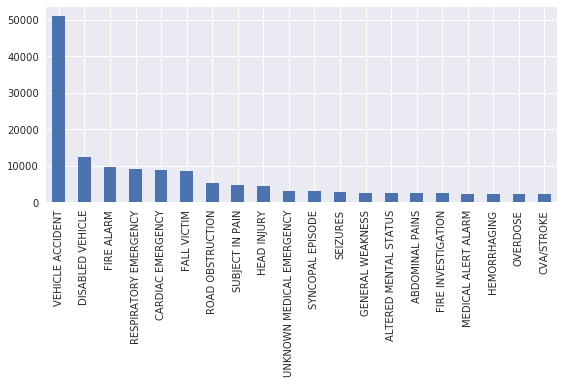

In [112]:
df['reason exp'].value_counts().nlargest(20).plot(kind='bar')
plt.tight_layout()

**Convert timestamp column to datetime**

**Add hour, month, year, day of week columns**

In [13]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [14]:
df['Hour'] = df['timeStamp'].apply(lambda t: t.hour)
df['Month'] = df['timeStamp'].apply(lambda t: t.month)
df['Year'] = df['timeStamp'].apply(lambda t: t.year)
df['Day'] = df['timeStamp'].apply(lambda t: t.day)
df['Day of Week'] = df['timeStamp'].apply(lambda t: t.weekday_name)
df['Beginning of Month'] = df['timeStamp'].apply(lambda t: t.is_month_start)
df['End of Month'] = df['timeStamp'].apply(lambda t: t.is_month_end)

**What reasons occur most on what days?**

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


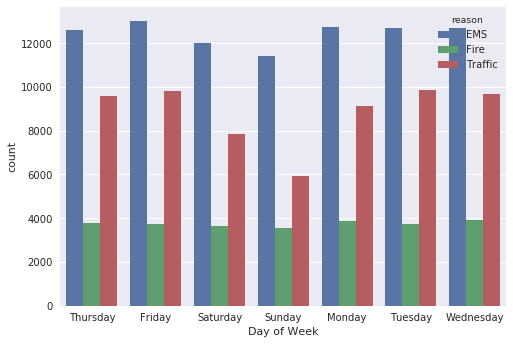

In [15]:
sns.countplot(x='Day of Week', data=df, hue='reason')

**What reasons occur most during what months?**

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


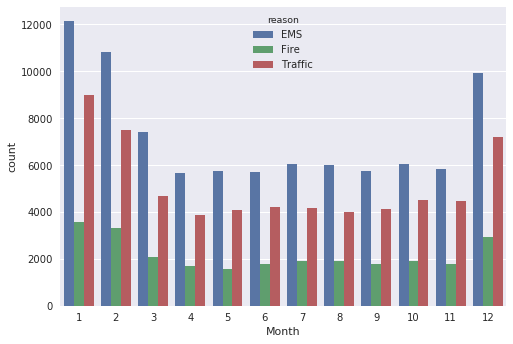

In [16]:
sns.countplot(x='Month', data=df, hue='reason')

**Total calls per month?**

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


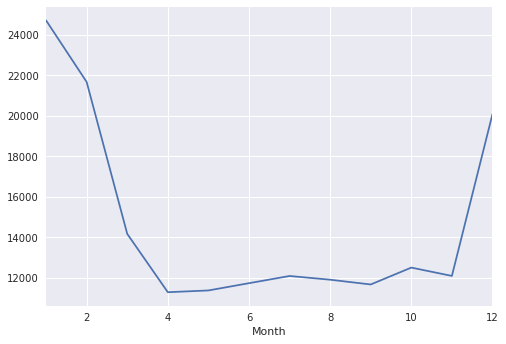

In [17]:
df.groupby('Month')['Month'].count().plot()

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


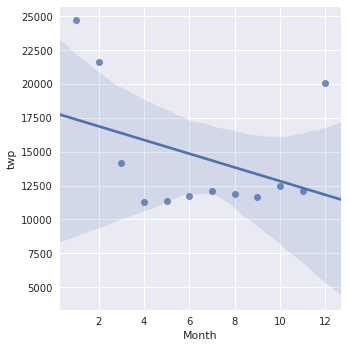

In [18]:
by_month = df.groupby('Month').count()
sns.lmplot(x='Month', y='twp', data=by_month.reset_index())

**Add date column and look at calls per date**

In [19]:
df['Date'] = df['timeStamp'].apply(lambda t: t.date())

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


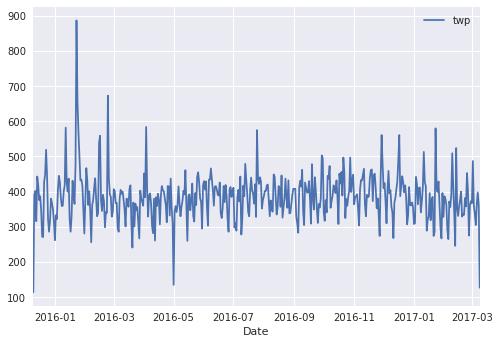

In [20]:
by_date = df.groupby('Date').count()
by_date.plot(y='twp')

**Look at specific reasons by dates**

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


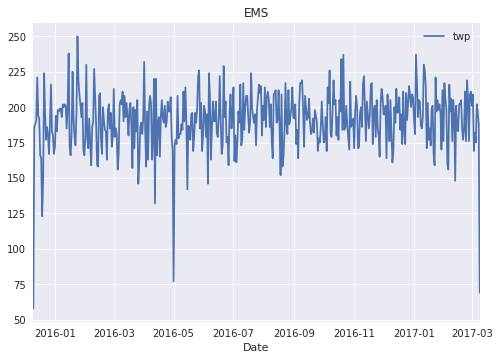

In [21]:
df[df['reason'] == 'EMS'].groupby('Date').count().plot(y='twp', title='EMS')

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


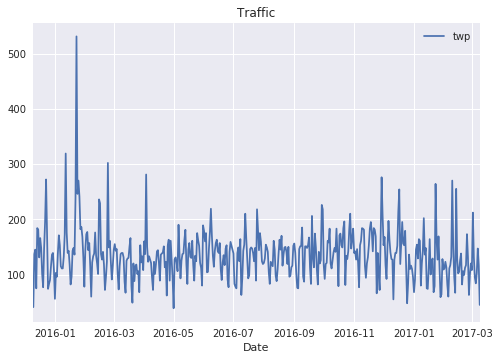

In [22]:
df[df['reason'] == 'Traffic'].groupby('Date').count().plot(y='twp', title='Traffic')

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


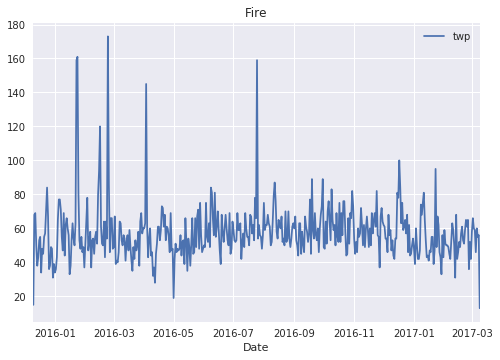

In [23]:
df[df['reason'] == 'Fire'].groupby('Date').count().plot(y='twp', title='Fire')

**How many occurences at what time of day and on what day?**

In [24]:
reason_by_day_hour = df.groupby(by=['Day of Week', 'Hour']).count()['reason'].unstack()
reason_by_day_hour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Friday,474,414,379,347,331,389,733,1123,1318,1368,...,1604,1758,1792,1808,1407,1321,1164,1007,926,766
Monday,476,379,372,322,385,450,720,1200,1517,1481,...,1504,1665,1672,1739,1503,1248,1045,818,740,550
Saturday,620,539,452,445,397,418,480,657,838,1147,...,1387,1399,1377,1387,1331,1289,1042,971,859,832
Sunday,642,565,536,468,391,409,484,661,820,1057,...,1201,1179,1162,1250,1215,1113,938,823,648,589
Thursday,476,353,398,311,327,444,801,1237,1453,1537,...,1549,1673,1629,1826,1463,1216,1074,947,736,604


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


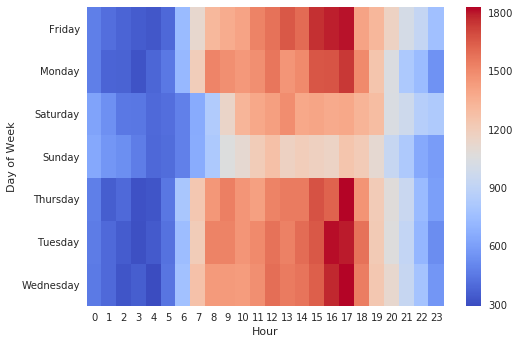

In [25]:
sns.heatmap(reason_by_day_hour, cmap='coolwarm')

/software/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


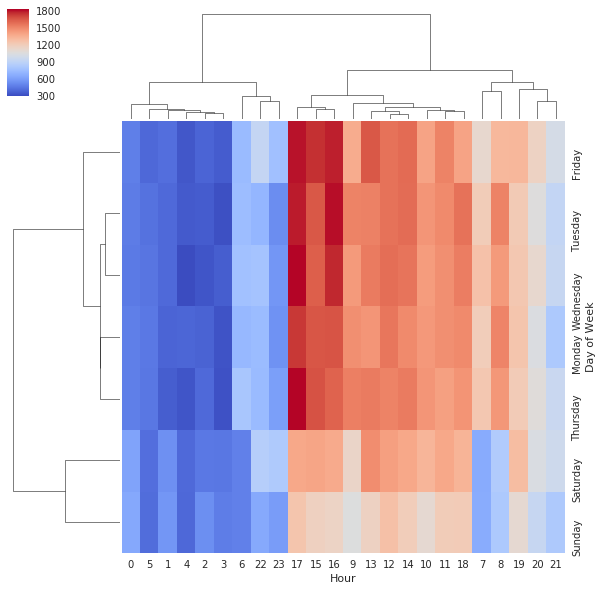

In [26]:
sns.clustermap(reason_by_day_hour, cmap='coolwarm')

**What about on month and day?**

In [27]:
reason_by_day_month = df.groupby(by=['Day of Week', 'Month']).count()['reason'].unstack()
reason_by_day_month.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day of Week,,,,,,,,,,,,
Friday,3527,3171,1881,1949,1725,1647,2042,1740,2195,1901,1699,3116
Monday,3706,3552,1900,1594,1776,1609,1685,1865,1552,2042,1682,2777
Saturday,3527,2871,1600,1736,1438,1376,1691,1423,1406,1935,1516,2975
Sunday,3470,2339,1402,1486,1413,1329,1667,1360,1235,1757,1281,2177
Thursday,3182,3189,2497,1592,1585,2055,1642,1579,2165,1625,1630,3264


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


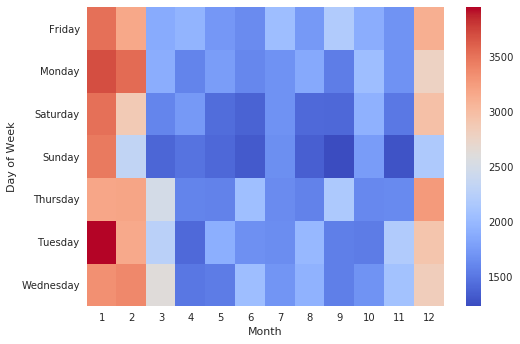

In [28]:
sns.heatmap(reason_by_day_month, cmap='coolwarm')

/software/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


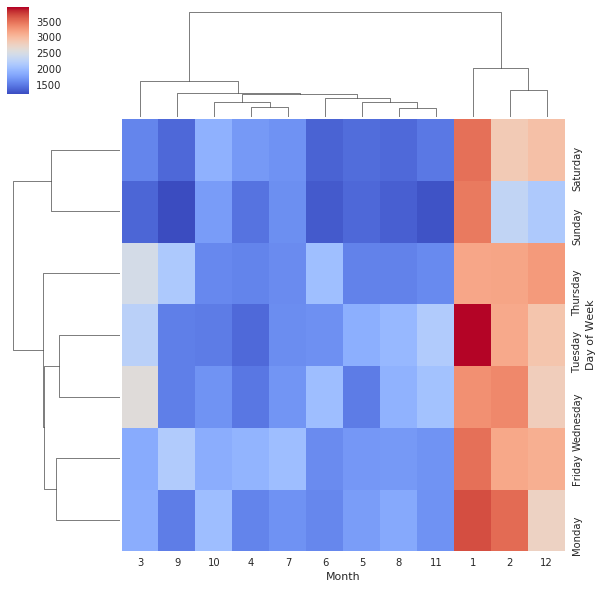

In [29]:
sns.clustermap(reason_by_day_month, cmap='coolwarm')

In [30]:
reason_by_day_month = df.groupby(by=['Day', 'Month']).count()['reason'].unstack()
reason_by_day_month.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day,,,,,,,,,,,,
1,570.0,762.0,774.0,452.0,136.0,432.0,411.0,387.0,408.0,341.0,364.0,410.0
2,644.0,847.0,888.0,386.0,342.0,406.0,298.0,402.0,408.0,317.0,384.0,426.0
3,765.0,794.0,727.0,584.0,359.0,429.0,310.0,402.0,330.0,376.0,388.0,372.0
4,823.0,653.0,704.0,409.0,342.0,354.0,289.0,419.0,310.0,341.0,392.0,310.0
5,809.0,666.0,602.0,329.0,362.0,304.0,383.0,420.0,283.0,445.0,353.0,406.0


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


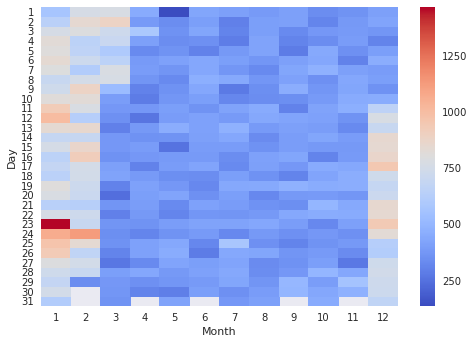

In [31]:
sns.heatmap(reason_by_day_month, cmap='coolwarm')

**Any correlations?**

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


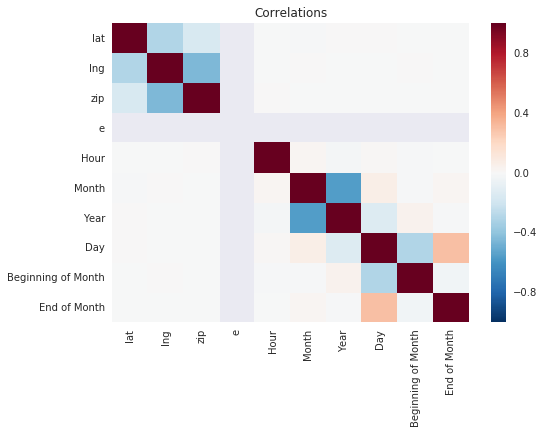

In [32]:
fig = sns.heatmap(df.corr())
fig.set_title('Correlations')